### Hidden

def search_restaurants(self, place: str) -> dict:
        """
        Searches for available restaurants in the specified place using TavilySearch.
        """
        tavily_tool = TavilySearch(topic="general", include_answer="advanced")
        # ddg = DuckDuckGoSearchRun()
        # ddg = DuckDuckGoSearchResults(max_results=10, output_format='list')
        # query = f"what are the top 10 restaurants and eateries in and around {place}."
        result = tavily_tool.invoke({"query": f"what are the top 10 restaurants and eateries in and around {place}."})
        # result = ddg.invoke({"query": query})
        # print(type(result))
        # pprint.pprint(result)
        if isinstance(result, dict) and result.get("answer"):
            return result["answer"]
        return result

### Actual

In [46]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_community.utilities.alpha_vantage import AlphaVantageAPIWrapper
from langchain.tools import tool
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain.tools import BaseTool
from langchain_tavily import TavilySearch
from langchain_community.tools import DuckDuckGoSearchRun, DuckDuckGoSearchResults
import json
from pydantic import BaseModel, Field
from typing import Optional, Type
from langchain.tools import Tool
import pprint
from langchain_openai import ChatOpenAI

In [2]:
## Langchain and Langsmith tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_PROJECT'] = os.getenv('LANGCHAIN_PROJECT')
os.environ["LANGCHAIN_TRACING_V2"]="true"

In [3]:
## Getting Groq API key
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
## Getting TAVILY API key
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
# print(os.getenv("TAVILY_API_KEY"))

EMBEDDING_MODEL = "all-MiniLM-L6-v2"
INFERENCE_MODEL = "gemma2-9b-it"

In [47]:
os.environ["ALPHAVANTAGE_API_KEY"] = os.getenv('ALPHAVANTAGE_API_KEY')
os.environ["OPENWEATHERMAP_API_KEY"] = os.getenv('OPENWEATHERMAP_API_KEY')
os.environ["WEATHER_API_KEY"] = os.getenv('WEATHER_API_KEY')
os.environ["EXCHANGE_RATE_API_KEY"] = os.getenv('EXCHANGE_RATE_API_KEY')
os.environ["GPLACES_API_KEY"] = os.getenv('GPLACES_API_KEY')


In [5]:
# llm = ChatGroq(
#     model_name="deepseek-r1-distill-llama-70b",
#     temperature=0
# )
llm = ChatOpenAI(
    model_name="o4-mini"
)
# response=llm.invoke("what is length of wall of china?")

## Custom Tools

### Test Tools

In [30]:
class Calculator:
    @staticmethod
    def multiply(a: int, b: int) -> int:
        """
        Multiply two integers.

        Args:
            a (int): The first integer.
            b (int): The second integer.

        Returns:
            int: The product of a and b.
        """
        return a * b

    @staticmethod
    def calculate_total(*x: float) -> float:
        """
        Calculate sum of the given list of numbers

        Args:
            x (list): List of floating numbers

        Returns:
            float: The sum of numbers in the list x
        """
        return sum(x)
    
    @staticmethod
    def calculate_daily_budget(total: float, days: int) -> float:
        """
        Calculate daily budget

        Args:
            total (float): Total cost.
            days (int): Total number of days

        Returns:
            float: Expense for a single day
        """
        return total / days if days > 0 else 0



In [36]:
calc = Calculator()
calc.calculate_total(1,2,3,4,5,6)

21

### Place Info Tool

In [9]:
class PlaceQueryInput(BaseModel):
    place: str = Field(..., description="Name of the place (e.g., Paris)")
    # query_type: str = Field(
    #     ...,
    #     description="Type of query: one of ['attractions', 'restaurants', 'activities', 'transportation']"
    # )

class PlaceSearchTool(BaseTool):
    name:str = "PlaceSearchTool"
    description:str = (
        "A tool to search for attractions, restaurants, activities, and available "
        "modes of transportation for a given place using TavilySearch from langchain_tavily."
    )
    args_schema: Type[BaseModel] = PlaceQueryInput
# class PlaceSearchTool:
#     def __init__(self):
#         pass

    @staticmethod
    @tool
    def search_attractions(place: str) -> dict:
        """
        Searches for attractions in the specified place using TavilySearch.
        """
        tavily_tool = TavilySearch(topic="general", include_answer="advanced")
        result = tavily_tool.invoke({"query": f"top attractive places in and around {place}"})
        if isinstance(result, dict) and result.get("answer"):
            return result["answer"]
        return result
    
    @staticmethod
    @tool
    def search_restaurants(place: str) -> dict:
        """
        Searches for available restaurants in the specified place using TavilySearch.
        """
        tavily_tool = TavilySearch(topic="general", include_answer="advanced")
        result = tavily_tool.invoke({"query": f"what are the top 10 restaurants and eateries in and around {place}."})
        if isinstance(result, dict) and result.get("answer"):
            return result["answer"]
        return result
    
    @staticmethod
    @tool
    def search_activity(place: str) -> dict:
        """
        Searches for popular activities in the specified place using TavilySearch.
        """
        tavily_tool = TavilySearch(topic="general", include_answer="advanced")
        result = tavily_tool.invoke({"query": f"activities in and around {place}"})
        if isinstance(result, dict) and result.get("answer"):
            return result["answer"]
        return result

    @staticmethod
    @tool
    def search_transportation(place: str) -> dict:
        """
        Searches for available modes of transportation in the specified place using TavilySearch.
        """
        tavily_tool = TavilySearch(topic="general", include_answer="advanced")
        result = tavily_tool.invoke({"query": f"What are the different modes of transportations available in {place}"})
        if isinstance(result, dict) and result.get("answer"):
            return result["answer"]
        return result
    
    def _run(self, query: str, **kwargs) -> str:
        """
        Runs the tool. The query is expected to be a JSON string with two keys:
          - "operation": One of ["attractions", "restaurants", "activities", "transportation"]
          - "place": The location to search.
          
        Example input:
          {"operation": "attractions", "place": "Paris"}
        """
        pass

In [8]:
# **Step 2: Convert tool into a LangChain-compatible function**
place_search_tool = PlaceSearchTool()
# place = "Kolkata"
attraction_tool = Tool(
    name="AttractionSearch",
    func=lambda place: place_search_tool._run(json.dumps({"operation": "attractions", "place": place})),
    description="Search for the attractions in a given place."
)
restaurant_tool = Tool(
    name="RestaurantSearch",
    func=lambda place: place_search_tool._run(json.dumps({"operation": "restaurants", "place": place})),
    description="Search for the best restaurants in a given place."
)
activity_tool = Tool(
    name="ActivitySearch",
    func=lambda place: place_search_tool._run(json.dumps({"operation": "activities", "place": place})),
    description="Search for the activities around a given place."
)
transportation_tool = Tool(
    name="TransportationSearch",
    func=lambda place: place_search_tool._run(json.dumps({"operation": "transportation", "place": place})),
    description="Search for the available mode of tranport system in a given place."
)

In [10]:
SYSTEM_PROMPT="You are a helpful assistant tasked to get the attractions, restaurants, activities and transportations of a " \
"given location using the list of tools provided. Obtain the informations as per the user requirement and then segregate " \
"the output as per the attractions, restaurants, activities and transportations"
place_tool = PlaceSearchTool()
tools=[multiply, add, currency_converter, 
       place_tool.search_attractions, 
       place_tool.search_restaurants, 
       place_tool.search_activity, 
       place_tool.search_transportation]
llm_with_tools=llm.bind_tools(tools)
# response=llm_with_tools.invoke(SYSTEM_PROMPT + "The hotel costs 130 Euro for 1 day exclusive of VAT. On top of this room rent, additional 3 EUR"
# "will be charged as VAT per day. I will be staying in this hotel for 3 days. What will be the total costing? I am from India." \
# "What will be the total cost in INR?")
# response=llm_with_tools.invoke(SYSTEM_PROMPT + "What is the best eateries of Kolkata?")
# response.pretty_print()
# response.tool_calls

In [9]:
SYSTEM_PROMPT="You are a helpful assistant tasked to get the attractions, restaurants, activities and transportations of a " \
"given location using the list of tools provided. Obtain the informations as per the user requirement and then segregate " \
"the output as per the attractions, restaurants, activities and transportations"
tools=[multiply, add, currency_converter, attraction_tool, restaurant_tool, activity_tool, transportation_tool]
llm_with_tools=llm.bind_tools(tools)
# response=llm_with_tools.invoke(SYSTEM_PROMPT + "The hotel costs 130 Euro for 1 day exclusive of VAT. On top of this room rent, additional 3 EUR"
# "will be charged as VAT per day. I will be staying in this hotel for 3 days. What will be the total costing? I am from India." \
# "What will be the total cost in INR?")
# response=llm_with_tools.invoke(SYSTEM_PROMPT + "What is the best eateries of Kolkata?")
# response.pretty_print()
# response.tool_calls

In [11]:
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

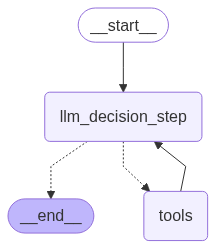

In [12]:
builder=StateGraph(MessagesState)
builder.add_node("llm_decision_step",function_1)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"llm_decision_step")
builder.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
builder.add_edge("tools","llm_decision_step")
react_graph=builder.compile()
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [13]:
message=[HumanMessage(content="Give me details about Kolkata")]
response = react_graph.invoke({"messages":message})
print(response)
pprint.pprint(response["messages"][-1].content)

{'messages': [HumanMessage(content='Give me details about Kolkata', additional_kwargs={}, response_metadata={}, id='cfa6e9f0-dd07-4088-a7b1-a811bc5b4d52'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m90EPvT4sM0RSP9AtNQxnkkY', 'function': {'arguments': '{"place":"Kolkata"}', 'name': 'search_attractions'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 401, 'total_tokens': 555, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 128, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-BjmSX8T9Lj4ggQIdvoKCRfDQDKwyQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3e829b00-bec7-4089-80c8-fa1013d3efd3-0', tool_calls=[{'name': 'search_attractions', 'args': {'place': 'Kolkata'}, 'id'

In [12]:
message=[HumanMessage(content="Give me details about Kolkata")]
response = react_graph.invoke({"messages":message})
print(response)
pprint.pprint(response["messages"][-1].content)

{"operation": "attractions", "place": "Kolkata"}
$$$$$$$$$$$$$$$$
{"operation": "restaurants", "place": "Kolkata"}
$$$$$$$$$$$$$$$$
{"operation": "activities", "place": "Kolkata"}
$$$$$$$$$$$$$$$$
{"operation": "transportation", "place": "Kolkata"}
$$$$$$$$$$$$$$$$
{'messages': [HumanMessage(content='Give me details about Kolkata', additional_kwargs={}, response_metadata={}, id='ad9a9c51-547f-4b58-8f64-4cf271194b5a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Bx87ghioVWnlZ672j3F9tbpc', 'function': {'arguments': '{"__arg1":"Kolkata"}', 'name': 'AttractionSearch'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 476, 'prompt_tokens': 415, 'total_tokens': 891, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerp

In [96]:
import pprint
import time
place_search_tool = PlaceSearchTool()
place = "Kolkata"
# print("Attractions using direct method:")
# pprint.pprint(place_search_tool.search_attractions(place))
# # time.sleep(30)
# print("Restaurants using direct method:")
# pprint.pprint(place_search_tool.search_restaurants(place))
# # time.sleep(30)
# print("Activities using direct method:")
# pprint.pprint(place_search_tool.search_activity(place))
# # time.sleep(30)
# print("Transportations using direct method:")
# pprint.pprint(place_search_tool.search_transportation(place))
# query = json.dumps({
#         "operation": "restaurants",
#         "place": place
#     })
# print("\nUsing _run method with query:")
# # pprint.pprint(tool._run(query))
# pprint.pprint(tool._run(query))

In [40]:
tools=[multiply, add, currency_converter, place_search_tool]

### Weather Tool

In [18]:
!pip install pyowm

   ---------------------------------------- 0.0/4.5 MB ? eta -:--:--
   ---------------------------------------- 4.5/4.5 MB 29.5 MB/s eta 0:00:00

   ---------------------------------------- 0/3 [geojson]
   ---------------------------------------- 0/3 [geojson]
   ---------------------------------------- 0/3 [geojson]
   ------------- -------------------------- 1/3 [PySocks]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   -------------------------- ------------- 2/3 [pyowm]
   --

In [20]:
from langchain.tools import BaseTool
from typing import Type
from pydantic import BaseModel, Field
import requests
from datetime import datetime, timedelta
from dateutil import parser

In [5]:
base_url = "https://api.openweathermap.org/data/2.5"

In [11]:
import requests
def get_current_weather(place:str):
    """Get current weather of a place"""
    try:
        url = f"{base_url}/weather"
        params = {
            "q": place,
            "appid": os.environ["OPENWEATHERMAP_API_KEY"],
        }
        response = requests.get(url, params=params)
        return response.json() if response.status_code == 200 else {}
    except Exception as e:
        raise e

In [12]:
get_current_weather("Kolkata")

{'coord': {'lon': 88.3697, 'lat': 22.5697},
 'weather': [{'id': 804,
   'main': 'Clouds',
   'description': 'overcast clouds',
   'icon': '04d'}],
 'base': 'stations',
 'main': {'temp': 299.4,
  'feels_like': 299.4,
  'temp_min': 299.4,
  'temp_max': 299.4,
  'pressure': 999,
  'humidity': 81,
  'sea_level': 999,
  'grnd_level': 998},
 'visibility': 10000,
 'wind': {'speed': 8.52, 'deg': 206, 'gust': 15.96},
 'clouds': {'all': 100},
 'dt': 1750320178,
 'sys': {'country': 'IN', 'sunrise': 1750288941, 'sunset': 1750337599},
 'timezone': 19800,
 'id': 1275004,
 'name': 'Kolkata',
 'cod': 200}

In [13]:
import requests
def get_forecast_weather(place:str):
    """Get weather forecast of a place"""
    try:
        url = f"{base_url}/forecast"
        params = {
            "q": place,
            "appid": os.environ["OPENWEATHERMAP_API_KEY"],
            "cnt": 10
        }
        response = requests.get(url, params=params)
        return response.json() if response.status_code == 200 else {}
    except Exception as e:
        raise e

In [14]:
get_forecast_weather("Kolkata")

{'cod': '200',
 'message': 0,
 'cnt': 10,
 'list': [{'dt': 1750323600,
   'main': {'temp': 299.77,
    'feels_like': 299.77,
    'temp_min': 299.77,
    'temp_max': 299.77,
    'pressure': 998,
    'sea_level': 998,
    'grnd_level': 998,
    'humidity': 80,
    'temp_kf': 0},
   'weather': [{'id': 500,
     'main': 'Rain',
     'description': 'light rain',
     'icon': '10d'}],
   'clouds': {'all': 100},
   'wind': {'speed': 7.64, 'deg': 203, 'gust': 13.64},
   'visibility': 10000,
   'pop': 0.92,
   'rain': {'3h': 0.64},
   'sys': {'pod': 'd'},
   'dt_txt': '2025-06-19 09:00:00'},
  {'dt': 1750334400,
   'main': {'temp': 299.86,
    'feels_like': 302.34,
    'temp_min': 299.86,
    'temp_max': 300.03,
    'pressure': 998,
    'sea_level': 998,
    'grnd_level': 998,
    'humidity': 81,
    'temp_kf': -0.17},
   'weather': [{'id': 500,
     'main': 'Rain',
     'description': 'light rain',
     'icon': '10d'}],
   'clouds': {'all': 100},
   'wind': {'speed': 6.64, 'deg': 200, 'gust': 

In [15]:
class WeatherForecastTool:
    def __init__(self, api_key:str):
        self.api_key = api_key
        self.base_url = "https://api.openweathermap.org/data/2.5"

    def get_current_weather(self, place:str):
        """Get current weather of a place"""
        try:
            url = f"{self.base_url}/weather"
            params = {
                "q": place,
                "appid": self.api_key,
            }
            response = requests.get(url, params=params)
            return response.json() if response.status_code == 200 else {}
        except Exception as e:
            raise e
    
    def get_forecast_weather(self, place:str):
        """Get weather forecast of a place"""
        try:
            url = f"{self.base_url}/forecast"
            params = {
                "q": place,
                "appid": self.api_key,
                "cnt": 10
            }
            response = requests.get(url, params=params)
            return response.json() if response.status_code == 200 else {}
        except Exception as e:
            raise e


In [17]:
wt = WeatherForecastTool(os.environ["OPENWEATHERMAP_API_KEY"])
wt.get_forecast_weather("Kolkata")

{'cod': '200',
 'message': 0,
 'cnt': 10,
 'list': [{'dt': 1750323600,
   'main': {'temp': 299.77,
    'feels_like': 299.77,
    'temp_min': 299.77,
    'temp_max': 299.77,
    'pressure': 998,
    'sea_level': 998,
    'grnd_level': 998,
    'humidity': 80,
    'temp_kf': 0},
   'weather': [{'id': 500,
     'main': 'Rain',
     'description': 'light rain',
     'icon': '10d'}],
   'clouds': {'all': 100},
   'wind': {'speed': 7.64, 'deg': 203, 'gust': 13.64},
   'visibility': 10000,
   'pop': 0.92,
   'rain': {'3h': 0.64},
   'sys': {'pod': 'd'},
   'dt_txt': '2025-06-19 09:00:00'},
  {'dt': 1750334400,
   'main': {'temp': 299.86,
    'feels_like': 302.34,
    'temp_min': 299.86,
    'temp_max': 300.03,
    'pressure': 998,
    'sea_level': 998,
    'grnd_level': 998,
    'humidity': 81,
    'temp_kf': -0.17},
   'weather': [{'id': 500,
     'main': 'Rain',
     'description': 'light rain',
     'icon': '10d'}],
   'clouds': {'all': 100},
   'wind': {'speed': 6.64, 'deg': 200, 'gust': 

### Currency Exchange Tool

In [ ]:
def currency_converter(from_curr: str, to_curr: str, value: float)->float:
    """
    Get the latest exchange rate of the two currencies

    Args:
        from_currency (str): The currency code in which the value is given.
        to_currency (str): The currency code in which the value needs to be converted.
        value (float): The value of the initial curency that is to be converted

    Returns:
        float: Value in the currency in which the amount is to be converted.
    """
    alpha_vantage = AlphaVantageAPIWrapper()
    response = alpha_vantage._get_exchange_rate(from_curr, to_curr)
    exchange_rate = response['Realtime Currency Exchange Rate']['5. Exchange Rate']
    return value * float(exchange_rate)

In [28]:
class CurrencyConverter:
    def __init__(self, api_key: str):
        self.base_url = f"https://v6.exchangerate-api.com/v6/{api_key}/latest/"
    
    def convert(self, amount:float, from_currency:str, to_currency:str):
        """Convert the amount from one currency to another"""
        url = f"{self.base_url}/{from_currency}"
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception("API call failed:", response.json())
        rates = response.json()["conversion_rates"]
        if to_currency not in rates:
            raise ValueError(f"{to_currency} not found in exchange rates.")
        return amount * rates[to_currency]
        

In [29]:
cc = CurrencyConverter(os.environ["EXCHANGE_RATE_API_KEY"])
cc.convert(1.14, "EUR", "INR")


113.33081999999999

### Search Places API

In [49]:
!pip install langchain-google-community[places]

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40854 sha256=0fa17738e1a5b5d5f66ab06dd99118311342022500f566239b94a6e5883296ab
  Stored in directory: c:\users\atriy\appdata\local\pip\cache\wheels\76\2a\24\5993a7b77c9a37b86f415096436a448c1babdd132066bdcb31
Successfully built googlemaps


  DEPRECATION: Building 'googlemaps' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'googlemaps'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [ ]:
from langchain_google_community import GooglePlacesTool, GooglePlacesAPIWrapper 
places_wrapper = GooglePlacesAPIWrapper(gplaces_api_key=os.environ["GPLACES_API_KEY"])
places_tool = GooglePlacesTool(api_wrapper=places_wrapper)

In [ ]:
from langchain_google_community import GooglePlacesTool, GooglePlacesAPIWrapper
class GooglePlaceSearchTool:
    def __init__(self, api_key: str):
        self.places_wrapper = GooglePlacesAPIWrapper(gplaces_api_key=api_key)
        self.places_tool = GooglePlacesTool(api_wrapper=self.places_wrapper)
    
    def google_search_attractions(self, place: str) -> dict:
        """
        Searches for attractions in the specified place using GooglePlaces.
        """
        # query = f"top attractions activities things to do in {place}"
        return self.places_tool.run(f"top attractive places in and around {place}")

In [60]:
gp = GooglePlaceSearchTool(os.environ["GPLACES_API_KEY"])
print(gp.google_search_attractions("Kolkata"))

1. Indian Museum
Address: 27, Jawaharlal Nehru Rd, Colootola, New Market Area, Dharmatala, Taltala, Kolkata, West Bengal 700016, India
Google place ID: ChIJ33o0YBF3AjoRrAtN-RkG158
Phone: 033 2252 1790
Website: https://hindi.indianmuseumkolkata.org/


2. James Prinsep Monument
Address: Strand Rd, Maidan, Fort William, Hastings, Kolkata, West Bengal 700021, India
Google place ID: ChIJEcecdeh3AjoRj-XwNn_Df9A
Phone: Unknown
Website: Unknown


3. St. Paul's Cathedral
Address: Rabindra Sadan, 1A, Cathedral Rd, Maidan, New Market Area, Kolkata, West Bengal 700071, India
Google place ID: ChIJMY9YQhR3AjoR5XEZx8wiZmQ
Phone: Unknown
Website: Unknown


4. Nicco park
Address: HM Block, Sector IV, Bidhannagar, Kolkata, West Bengal 700106, India
Google place ID: ChIJ32eM87V1AjoRkTcxeNNzLYQ
Phone: Unknown
Website: http://niccoparks.com/


5. Howrah Bridge
Address: Kolkata, West Bengal 700001, India
Google place ID: ChIJG-seu793AjoRmRFBjKoKhMk
Phone: Unknown
Website: https://howrah.gov.in/bn/tourist-pl

In [55]:
pprint.pprint(places_tool.run("Top restaurants in Kolkata"))

('1. Spice Kraft\n'
 'Address: 54/1/2A, Hazra Rd, near HDFC Bank, Dover Terrace, Ballygunge, '
 'Kolkata, West Bengal 700019, India\n'
 'Google place ID: ChIJQa8kotd2AjoReFWjxqT_HCI\n'
 'Phone: 098312 23311\n'
 'Website: https://spice-kraft-restaurant.shop/\n'
 '\n'
 '\n'
 '2. Carpe Diem\n'
 'Address: 18M, Park St, Park Street area, Kolkata, West Bengal 700071, India\n'
 'Google place ID: ChIJgXo27g93AjoRKKsNh9EZbRo\n'
 'Phone: 062923 21580\n'
 'Website: https://www.facebook.com/CarpeDiemKolkata/\n'
 '\n'
 '\n'
 '3. Kolkata Rajbari\n'
 'Address: 56, Jatindas Rd, lake Terrace, Kalighat, Kolkata, West Bengal '
 '700029, India\n'
 'Google place ID: ChIJMczfjrl3AjoRE2gjgVg91sw\n'
 'Phone: 098316 22556\n'
 'Website: http://kolkatarajbari.in/\n'
 '\n'
 '\n'
 '4. The Saffron Tree\n'
 'Address: 100, Raja Basanta Roy Rd, lake Terrace, Kalighat, Kolkata, West '
 'Bengal 700029, India\n'
 'Google place ID: ChIJabK9P95xAjoRKEjSKGnoUwc\n'
 'Phone: 098312 23311\n'
 'Website: https://m.facebook.com/t